## **PCA de l'AMO**


# Récupère les données

In [ ]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!apt-get -qq install python-cartopy python3-cartopy

'apt-get' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [ ]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
# colab requires a specific installation of cartopy
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;    # cartopy and shapely don't work well together at the moment...
!pip install shapely --no-binary shapely; # so reinstall a version that will work

'apt-get' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'


In [ ]:
# set up our libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline

In [ ]:
# general setup
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from scipy import signal # for periodogram


#from dask_ml.decomposition import PCA
from sklearn.decomposition import PCA
# import the LinearRegression method from scikit-learn
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
def load_data(string):
  # and load in the SSH data
  df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
  df_ssh = df.query(string)

  # setup the gcs access
  gcs = gcsfs.GCSFileSystem(token='anon')

  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df_ssh.zstore.values[-1]

  # create a mapping interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  ds = ds.sel(y=slice(200,310), x=slice(190, 280))
  return ds

In [ ]:
def Ano_sst(ds, correct, rollLen):
  tos = ds.tos
  if correct:  
    tos_trend = getTrend(tos)

    tos = tos  - tos_trend # on enleve la tendance

  
  #tos_mean= tos.mean('y').mean('x')
  tos_mean = tos_mean.rolling(time=rollLen  , center=True).mean()#

  return tos_mean

In [ ]:
def getTrend(tos):
  # create a generic instance the model
  model = LinearRegression()

  tim = np.arange(0,len(tos.time))
  # fit the model
  # (we have to add [:,None] because the method expects to receive 2D arrays as input data)
  model.fit(tim[:,None], tos.mean('y').mean('x').values[:,None])

  # get the predicted values of ŷ using the model:
  tos_trend = model.predict(tim[:,None])
  tos_trend=xr.DataArray(tos_trend.squeeze(),dims=('time'),coords={'time':tos['time']})
  return tos_trend

In [ ]:
ds_ssp126 = load_data("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp126' & institution_id == 'IPSL'")


C:\Users\UserENM\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
tos = ds_ssp126.tos
tos_mean = tos.rolling(time=84, center=True).mean()
tos_mean

<xarray.DataArray (time: 1032, y: 110, x: 90)>
dask.array<where, shape=(1032, 110, 90), dtype=float32, chunksize=(247, 110, 90), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
Dimensions without coordinates: y, x

C:\Users\UserENM\anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


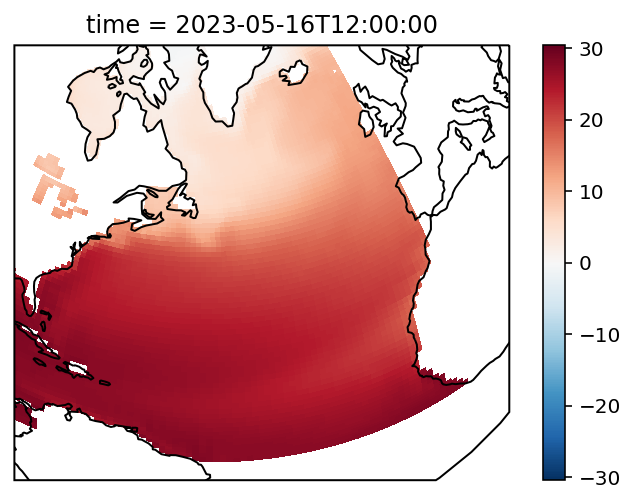

In [ ]:
# select the projection that we want
ax = plt.axes(projection=ccrs.Orthographic(-50,55,));
# then we set the latitude limits on our figure
ax.set_extent([-80, 0, 0, 65], ccrs.PlateCarree())
# plot the data using xarray
tos_mean[100].plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='nav_lon', y='nav_lat', add_colorbar=True); 
# and finally add the coastlines
ax.coastlines();

In [ ]:
SIC = tos_mean[50:70]